# Ejercicio clasificación supervisada

Importo las librerías necesarias para el script

In [1]:
from pathlib import Path
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pprint
from IPython.display import display
from modulos.calcula_indices import calcula_indices_spyndex
from modulos.conecta_gee import conecta_gee
from modulos.graficos_lineas import grafico_lineas

Inicializo GEE usando el módulo conecta_gee.py

Para hacer esto utilizo el módulo conecta_gee que ya creé en el ejercicio 6.1 de umbralización.

In [2]:
# Inicializo Earth Engine y el mapa interactivo
proyecto_gee = "geoforest-480217"
conecta_gee(proyecto_gee)
Map = geemap.Map()

Configuro las rutas de entrada y salida y compruebo que la información vectorial con los polígonos que he dibujado y la zona de estudio (municipio de La Zubia en Granada) están en su sitio

In [3]:
base_dir = Path.cwd()
ruta_entradas = base_dir / "entradas"
ruta_salidas = base_dir / "salidas"
ruta_mapas_html = ruta_salidas / "mapas_html_supervisada"
ruta_gpkg = ruta_entradas / "infoVectorial.gpkg"

# Comprueba si existe ruta_mapas_html y si no existe la crea
ruta_mapas_html.mkdir(parents=True, exist_ok=True)

# Si el gpkg no está en su sitio manda un aviso
if not ruta_gpkg.exists():
    raise FileNotFoundError(f"El archivo {ruta_gpkg} no existe")

## Carga de información vectorial

Cargo los datos de los polígonos que he dibujado. Están guardados en un geopackage, que creo que es más eficiente que un shapefile. Las clases que he dibujado son:
- forestal
- asfalto
- edificios
- cultivos
- suelo

Quizás se queden cortos, he dibujado 25 por cada clase, si tengo tiempo dibujo más.

Además de cargar las capas, compruebo si están en epsg:4326 (src que usa GEE) y si no lo están las reproyecto a ese src.

El polígono del término municipal viene de los Datos Espaciales de Referencia de Andalucía (Instituto de Estadística y Cartografía de Andalucía).

In [4]:
# CArga la capa con los polígonos dibujados
capa_poligonos = gpd.read_file(ruta_gpkg, layer="usos_suelo")

# Carga la capa con el término municipal
capa_municipio = gpd.read_file(ruta_gpkg, layer="la_zubia")

# Si el src de la capa no es 4326 la reproyecta
if capa_poligonos.crs != "EPSG:4326":
    capa_poligonos = capa_poligonos.to_crs("EPSG:4326")

if capa_municipio.crs != "EPSG:4326":
    capa_municipio = capa_municipio.to_crs("EPSG:4326")

# Convierte el geodataframe de polígonos en una ee.FeatureCollection y lo sube a gee
poligonos_dibujados = geemap.gdf_to_ee(capa_poligonos)
municipio = geemap.gdf_to_ee(capa_municipio)

## División entrenamiento / validación

En esta celda hago la segregación de los polígnos que he dibujado en entrenamiento / validación (70/30).

Además imprimo alguna estadística para ver como quedan repartidos los polígonos

In [5]:
# Creo una columna con valores aleatorios para dividir el dataset
# Uso una semilla (seed) para reproducibilidad
landcover_random = poligonos_dibujados.randomColumn("random", seed=123)

# Defino el umbral de división (70/30)
split = 0.7

# Filtro para obtener los conjuntos
dataset_entrenamiento = landcover_random.filter(ee.Filter.lt("random", split))
dataset_validacion = landcover_random.filter(ee.Filter.gte("random", split))

# Muestro alguna estadística
print(f"Total polígonos: {poligonos_dibujados.size().getInfo()}")
print(f"Polígonos de entrenamiento: {dataset_entrenamiento.size().getInfo()}")
print(f"Polígonos de validación: {dataset_validacion.size().getInfo()}")

Total polígonos: 125
Polígonos de entrenamiento: 92
Polígonos de validación: 33


## Procesado de las imágenes de GEE

Cargo las imágenes de Sentinel-1 y Sentinel-2 que voy a usar en el resto del script.

He elegido imágenes de primavera porque en esta zona la mayoría de cultivos son de secano y en esta época ya estarán brotados y no se confundirán con la clase de suelo desnudo.

In [6]:
# Cargo las imágenes de gee
imagen_sentinel_2 = ee.Image("COPERNICUS/S2_SR_HARMONIZED/20250427T105641_20250427T110517_T30SVG")
imagen_sentinel_1 = ee.Image("COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20250404T061912_20250404T061937_058603_074101_90FC")

### Procesado de Sentinel-2

En esta celda hago varias cosas para preparar la imagen de Sentinel-2.

- Elimino las nubes creando una máscara de nubes usando la banda SCL que tienen las imágenes de Sentinel-2. Para esto selecciono los píxeles con valores 3, 8, 9 y 10 (sombreas de nubes, nubes con probabilidad media, nubes con probabilidad alta y cirros) y los reclasifico a 0, creando una máscara, donde los píxeles con valor 1 son los que nos interesan y los de valor 0 las nubes, que aplico a la imagen de Sentinel-2.
- Escalo los valores de las bandas a valores entre 0 y 1.
- Centro el mapa que voy a mostrar con el dataset de entrenamiento que he configurado más arriba.
- Configuro una visualización de la capa para mostrar un falso color infrarrojo estirando la imagen a 0,3 para que se distinga mejor los contrastes.
- Añado las imágenes al mapa
  - Sentinel-2
  - Polígonos de entrenamiento
  - Polígonos de validación

In [7]:
# Enmascaro las nubes usando la banda SCL de Sentinel-2
# En la máscara los píxeles con valor 3, 8, 9, 10 se reclasifican a 0 y el resto a 1
scl = imagen_sentinel_2.select("SCL")
mascara_nubes = scl.remap([3, 8, 9, 10], [0, 0, 0, 0], 1).rename("mask")
# Aplico la máscara
sentinel2_enmascaradas = imagen_sentinel_2.updateMask(mascara_nubes)

# Escalo los valores de las bandas de la imagen a valores de 0 a 1
bandas_s2 = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]
sentinel2 = sentinel2_enmascaradas.select(bandas_s2).multiply(0.0001)

# Creo un mapa para mostrar la imágen de Sentinel-2
mapa_sentinel2 = geemap.Map()

# Centro el mapa en la zona de estudio
mapa_sentinel2.centerObject(dataset_entrenamiento, 14)

# Configuro la visualización para usar un falso color infrarrojo
vis_params = {
    "min": 0,
    "max": 0.3,
    "bands": ["B8", "B4", "B3"]
}

# Añado la capa de Sentinel-2 al mapa
mapa_sentinel2.addLayer(sentinel2, vis_params, "Sentinel-2 falso color infrarrojo")

# Añado las capas de entrenamiento y validación
mapa_sentinel2.addLayer(dataset_entrenamiento, {"color": "blue"}, "Polígonos Entrenamiento")
mapa_sentinel2.addLayer(dataset_validacion, {"color": "yellow"}, "Polígonos Validación")

# Guardo el mapa como HTML
mapa_sentinel2.to_html(filename=str(ruta_mapas_html / "mapa_sentinel2.html"))

# Muestro el mapa
mapa_sentinel2

Map(center=[37.11362263569901, -3.575394365993651], controls=(WidgetControl(options=['position', 'transparent_…

#### Análisis de las firmas espectrales de Sentinel-2

Creo un gráfico donde muestro el comportamiento de las distintas bandas de Sentinel-2 para cada una de las clases que estoy usando.

Para ello cojo los datos de Sentinel-2 desde GEE, los enmascaro para coger solo los datos de dentro de los polígonos de entrenamiento y los meto en un dataframe de pandas para poder trabajar con esos datos y dibujar el gráfico.

Para mostrar la leyenda combino los datos de las columnas uso_suelo y uso_suelo_desc de la capa de los polígonos de entrenamiento para que quede más claro el gráfico.

Para que sea más fácil y los gráficos estén normalizados, he creado un módulo llamado grafico_lineas usando seaborn, para poder usarlo cada vez que se genere un gráfico de este tipo.

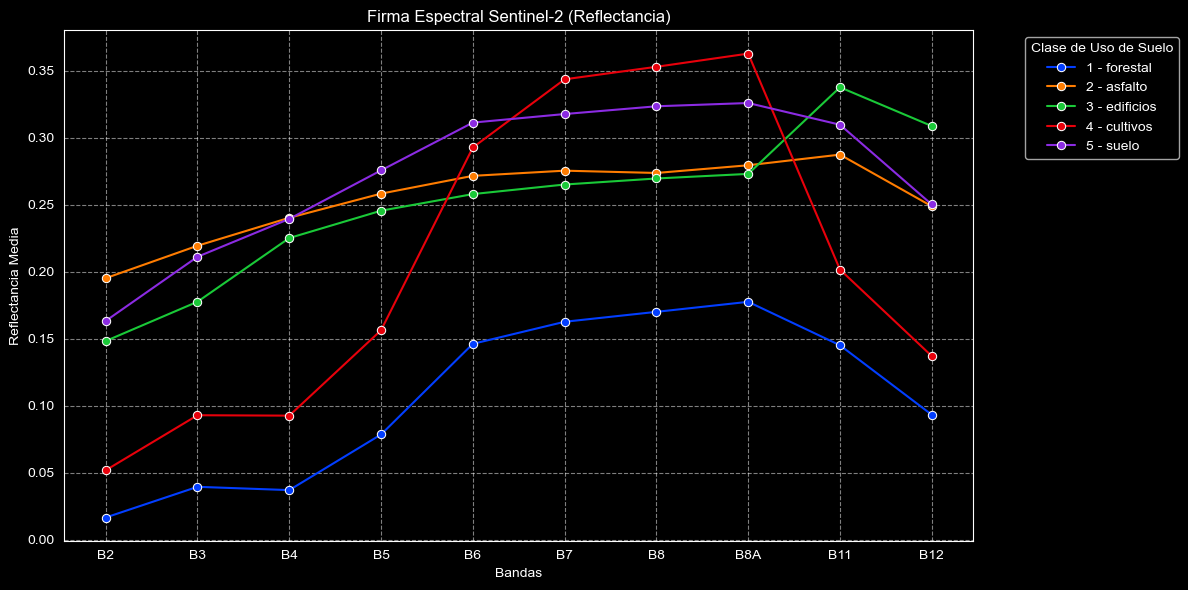

In [8]:
# Creo un dataset con las estadísticas de las bandas de la imagen
estadisticas_sentinel2 = sentinel2.select(bandas_s2).reduceRegions(
    collection=dataset_entrenamiento,
    reducer=ee.Reducer.mean(),
    scale=20
)

# Meto los datos de las bandas de SEntinel-2 dentro de los polígonos en un dataframe de pandas
df_s2 = geemap.ee_to_df(estadisticas_sentinel2)

# Preparo los datos creando una nueva columna que combina uso_suelo y uso_suelo_desc para usarla en la leyenda del gráfico
df_s2["Etiqueta"] = df_s2["uso_suelo"].astype(str) + " - " + df_s2["uso_suelo_desc"]
columna_hue = "Etiqueta"

df_s2_largo = df_s2.melt(
    id_vars=[columna_hue],
    value_vars=bandas_s2,
    var_name="Banda",
    value_name="Reflectancia"
)

# Gráfico de líneas
grafico_lineas(
    df=df_s2_largo,
    x="Banda",
    y="Reflectancia",
    hue=columna_hue,
    titulo="Firma Espectral Sentinel-2 (Reflectancia)",
    xlabel="Bandas",
    ylabel="Reflectancia Media",
    legend_title="Clase de Uso de Suelo"
)

### Procesado de Sentinel-1

Hago el procesado de la imagen de Sentinel-1 usando solo las bandas de VV y VH.

Como la imagen de Sentinel-1 viene ya en escala logarítmica no hay que cambiarla a dB.

In [9]:
radar = imagen_sentinel_1.select(["VV", "VH"])
vv = radar.select("VV")
vh = radar.select("VH")

# El ratio en dB es la resta al estar ya en escala logarítmica
ratio = vv.subtract(vh).rename("VV_Ratio")
radar_final = vv.addBands(vh).addBands(ratio)

# Creo un mapa para mostrar esta imagen
mapa_sentinel1 = geemap.Map()

# Centro el mapa en la zona de estudio
mapa_sentinel1.centerObject(dataset_entrenamiento, 14)

# Creo una rampa de color para aplicar a la banda VV
vis_params_vv = {
    "min": -25,
    "max": 0,
    "palette": ["blue", "purple", "cyan", "green", "yellow", "red"]
}

# Añado la capa de Sentinel-1 al mapa
mapa_sentinel1.addLayer(radar_final.select("VV"), vis_params_vv, "Sentinel-1 VV")

# Añado las capas de entrenamiento y validación
mapa_sentinel1.addLayer(dataset_entrenamiento, {"color": "blue"}, "Polígonos Entrenamiento")
mapa_sentinel1.addLayer(dataset_validacion, {"color": "yellow"}, "Polígonos Validación")

# Guardo el mapa como HTML
mapa_sentinel1.to_html(filename=str(ruta_mapas_html / "mapa_sentinel1.html"))

# Muestro el mapa
mapa_sentinel1

Map(center=[37.1136226357536, -3.5753943659360132], controls=(WidgetControl(options=['position', 'transparent_…

#### Análisis de las firmas de Sentinel-1

Hago el análisis de las firmas de Sentinel-1 para ver el comportamiento por clase.

Para esto hago lo mismo que he hecho más arriba con Sentinel-2, convierto los datos de Sentinel-1 dentro de los polígonos de entrenamiento a un dataframe de pandas para poder hacer el gráfico.

Utilizo el módulo graficos_lineas que expliqué en el análisis de firmas espectrales de Sentinel-2

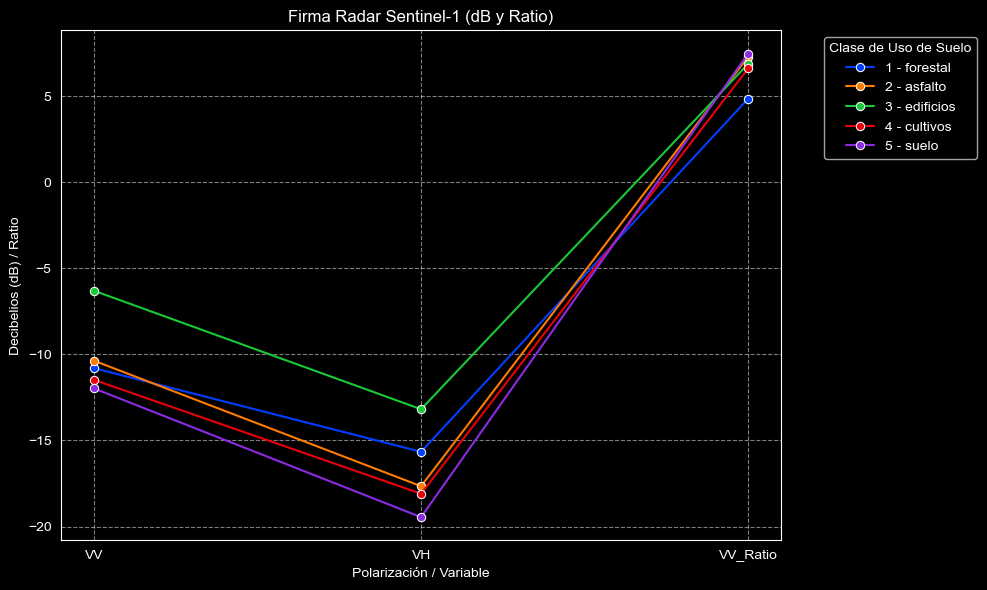

In [10]:
# Defino las bandas de la imagen de Sentinel-1
s1Bands = ["VV", "VH", "VV_Ratio"]

# Calculo la media de cada banda S1 para cada polígono para cada clase del dataset de entrenamiento
estadisticas_sentinel_1 = radar_final.select(s1Bands).reduceRegions(
    collection=dataset_entrenamiento,
    reducer=ee.Reducer.mean(),
    scale=10
)

# Convierto los datos a un dataframe de pandas
df_s1 = geemap.ee_to_df(estadisticas_sentinel_1)

# Preparo los datos para el gráfico concatenando uso_suelo y uso_suelo_desc para la leyenda
df_s1["Etiqueta"] = df_s1["uso_suelo"].astype(str) + " - " + df_s1["uso_suelo_desc"]
columna_hue = "Etiqueta"

df_s1_melt = df_s1.melt(
    id_vars=[columna_hue],
    value_vars=s1Bands,
    var_name="Banda",
    value_name="dB / Ratio"
)

# Gráfico de líneas
grafico_lineas(
    df=df_s1_melt,
    x="Banda",
    y="dB / Ratio",
    hue=columna_hue,
    titulo="Firma Radar Sentinel-1 (dB y Ratio)",
    xlabel="Polarización / Variable",
    ylabel="Decibelios (dB) / Ratio",
    legend_title="Clase de Uso de Suelo",
    figsize=(10, 6)
)

### Cálculo de índices espectrales

Aquí calculo los índices que me puedan interesar.

Para calcular estos índices uso la librería [spyndex](https://github.com/awesome-spectral-indices/spyndex/) que utiliza los datos del proyecto [Awesome Spectral Indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices) y que está adaptado para los datos de Sentinel-2, Landsat y MODIS. Esto está implementado en el módulo calcula_indices.

Al ser varios índices el resultado se guarda en una imagen de varias bandas, una por índice.

In [11]:
# Lista de índices
lista_indices = ["NDVI", "NDTI", "MNDWI"]

indices = calcula_indices_spyndex(sentinel2, lista_indices)

# Creo un mapa para mostrar uno de los índices (NDVI)
mapa_indices = geemap.Map()

# Centro el mapa en la zona de estudio
mapa_indices.centerObject(dataset_entrenamiento, 14)

# Configuro la visualización para el NDVI
vis_params_ndvi = {
    "min": -0.2,
    "max": 0.8,
    "palette": ["red", "yellow", "green"]
}

# Añado la capa de NDVI al mapa
mapa_indices.addLayer(indices.select("NDVI"), vis_params_ndvi, "NDVI")

# Añado las capas de entrenamiento y validación
mapa_indices.addLayer(dataset_entrenamiento, {"color": "blue"}, "Polígonos Entrenamiento")
mapa_indices.addLayer(dataset_validacion, {"color": "yellow"}, "Polígonos Validación")

# Guardo el mapa como HTML
mapa_indices.to_html(filename=str(ruta_mapas_html / "mapa_indices.html"))

# Muestro el mapa
mapa_indices

Map(center=[37.11362263569901, -3.575394365993651], controls=(WidgetControl(options=['position', 'transparent_…

### Preparación del dataset con los datos de todas la imágenes

Aquí creo una nueva imagen donde están los datos de Sentinel-1, Sentiel-2 e índices.

In [12]:
# Uno los datos de Sentinel-2 (reflectancia), Sentinel-1 (radar) e índices en una nueva imagen
datos_entrada = sentinel2.addBands(radar_final).addBands(indices)

## Preparación de datos para el modelo

En este bloque de código preparo los datos para el modelo.

Para esto, en un primer paso, creo una matriz de entrenamiento donde extraigo los valores de los píxeles de todas las bandas de *datos_entrada* que están dentro de los polígonos de entreamiento.

Después imprimo por pantalla algunas estadísticas del entrenamiento.

In [13]:
# Columna con los datos para las etiquetas
label = "uso_suelo"

# Creo las muestras de entrenamiento cruzando el raster con los polígonos cargados
training = datos_entrada.sampleRegions(
    collection=dataset_entrenamiento,
    properties=[label],
    scale=10,
    geometries=True
)

print("Muestreo finalizado.")
print("Número total de píxeles de entrenamiento:", training.size().getInfo())
print("Primer elemento de entrenamiento:", training.first().getInfo())

Muestreo finalizado.
Número total de píxeles de entrenamiento: 161
Primer elemento de entrenamiento: {'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [-3.579435648870267, 37.10524767931434]}, 'id': '0_0', 'properties': {'B11': 0.1507, 'B12': 0.10300000000000001, 'B2': 0.0111, 'B3': 0.0323, 'B4': 0.0337, 'B5': 0.0693, 'B6': 0.11120000000000001, 'B7': 0.12000000000000001, 'B8': 0.1305, 'B8A': 0.1356, 'BI': 0.13128834355828223, 'MNDWI': -0.6469945355191258, 'NDTI': 0.02121212121212119, 'NDVI': 0.58952496954933, 'VH': -18.570353204332697, 'VV': -10.926414805068319, 'VV_Ratio': 7.643938399264378, 'uso_suelo': 1}}


Compruebo si las clases están equilibradas en cuanto al número de píxeles.

In [14]:
print("Equilibrio de muestras (píxeles por clase):", training.aggregate_histogram(label).getInfo())

Equilibrio de muestras (píxeles por clase): {'1': 33, '2': 49, '3': 33, '4': 25, '5': 21}


### Entrenamiento de Random Forest

Aquí entreno random forest indicándole que cree solo 4 árboles. No sé si me dará el ordenador para más árboles.

In [15]:
# Creo el clasificador con 4 árboles y los datos de entrenamiento (training)
modelo = ee.Classifier.smileRandomForest(numberOfTrees=4).train(
    features=training,
    classProperty=label,
    inputProperties=datos_entrada.bandNames()
)

### Gráfico de importancia de variables (normalizadas)

Aquí creo un gráfico con la importancia de las variables normalizadas para ver qué bandas son más importantes en el modelo.

Lo he ordenado de mayor a menor de izquierda a derecha que me resulta más fácil de interpretar.

Para hacer esto:
- Creo un diccionario con los metadatos del modelom, donde se incluyen los datos de la importancia de cada banda
- Convierto el diccionario en un dataframe de pandas para poder hacer el gráfico
- Calculo el valor total de todas la importancias
- Calculo la importancia normalizada ocn respecto al valor total de importancia
- Creo el gráfico y lo muestro
- Imprimo la tabla de importancia de cada banda

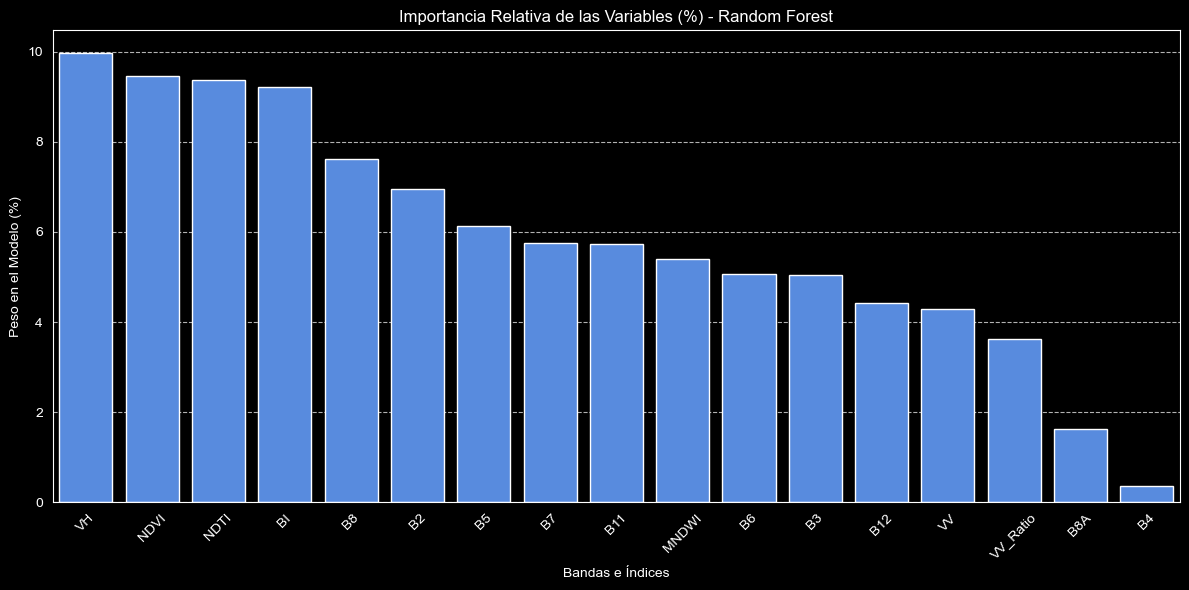

Tabla de Importancia Relativa:


,Importancia,Importancia relativa (%)
VH,1.785888,9.971824
NDVI,1.694418,9.461087
NDTI,1.679955,9.380328
BI,1.649317,9.209255
B8,1.363837,7.615231
B2,1.243385,6.942665
B5,1.097196,6.126391
B7,1.031689,5.760622
B11,1.027778,5.738781
MNDWI,0.965256,5.389680


In [16]:
# Creo el diccionario con los datos de importancia
explanation = modelo.explain()
importancia = explanation.get("importance").getInfo()

# Convierto el diccionario en un dataframe de pandas
df_importancia = pd.DataFrame.from_dict(importancia, orient="index", columns=["Importancia"])

# Calculo el total de la suma de importancias
importancia_total = df_importancia["Importancia"].sum()

# Hago la normalización con respecto a la suma de importancias
df_importancia["Importancia relativa (%)"] = (df_importancia["Importancia"] / importancia_total) * 100

# Ordeno el gráfico de mayor a menor
df_importancia = df_importancia.sort_values(by="Importancia relativa (%)", ascending=False)

# Genero el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_importancia,
    x=df_importancia.index,
    y="Importancia relativa (%)",
    color="#4285F4" # Color azul uniforme
)

plt.title("Importancia Relativa de las Variables (%) - Random Forest")
plt.xlabel("Bandas e Índices")
plt.ylabel("Peso en el Modelo (%)")
plt.xticks(rotation=45) # Rotar etiquetas si son muchas
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

print("Tabla de Importancia Relativa:")
display(df_importancia)

## Clasificación de la imagen

Aquí hago la clasificación de la imagen con el modelo entrenado y muestro el mapa.

La imagen la muestro usando la función randomVisualizer() de GEE que muestra una imagen aisgnándole un color al azar a cada valor único de los píxeles de la primera banda

In [17]:
# Clasifico la imagen completa (todas las bandas del stack) con el modelo
clasificacion = datos_entrada.classify(modelo)

# Recorto por el municipio para que no consuma más recursos de la cuenta
clasificacion_clip = clasificacion.clip(municipio)

# CReo el mapa para ver la clasificación
mapa_clasificacion = geemap.Map()

# Visualización
# Usamos randomVisualizer() para diferenciar clases automáticamente
mapa_clasificacion.addLayer(clasificacion_clip.randomVisualizer(), {}, "Clasificación supervisada con random forest")

# Centrar en el municipio
mapa_clasificacion.centerObject(municipio, 12)

# Guardo el mapa como HTML
mapa_clasificacion.to_html(filename=str(ruta_mapas_html / "mapa_clasificacion.html"))

# Mostrar el mapa
display(mapa_clasificacion)

Map(center=[37.110047506406076, -3.572004208010069], controls=(WidgetControl(options=['position', 'transparent…

## Evaluación del modelo

### Matriz de confusión

Aquí muestro por pantalla la matriz de confusión y la precisión del modelo.

Con esto se puede ver como se comporta el modelo asignando clases a los píxeles de cada polígono de entrenamiento (70%).

En este caso devuelve una matriz muy ajustada
- La clase forestal la clasifica sin problema
- La clase asfalto la clasifica bien menos por un píxel que clasifica como suelo
- La clase edificios la clasifica bien menos por un píxel que clasifica como asfalto
- La clase cultivos la clasifica bien menos por un píxel que clasifica como suelo
- La clase suelo la clasifica en su mayoría menos por dos píxeles que clasifica como asfalto y otros dos como cultivos

Es posible que los fallos se deban a errores en la digitalización de los polígonos de entrenamiento al asignar etiquetas o acercarse demasiado a los bordes.

Devuelve un valor de precisión del entrenamiento del 0,95 que es bastante alto.Habrá que compararlo con el valor de la matriz de validación para ver si el modelo está sobreajustado o no.

In [18]:
# Obtengo la matriz de confusión del clasificador entrenado
matriz_confusion = modelo.confusionMatrix()

# Imprimo por pantalla la matriz de error
print("Matriz de confusión:")
pprint.pprint(matriz_confusion.getInfo())

# Imprimo la precisión global
print("Precisión del entrenamiento:", matriz_confusion.accuracy().getInfo())

Matriz de confusión:
[[0, 0, 0, 0, 0, 0],
 [0, 33, 0, 0, 0, 0],
 [0, 0, 48, 0, 1, 0],
 [0, 0, 1, 32, 0, 0],
 [0, 0, 0, 0, 24, 1],
 [0, 0, 3, 0, 1, 17]]
Precisión del entrenamiento: 0.9565217391304348


### Creación de las muestras de validación

En este bloque de código creo las muestras de validación, usando el dataset de validación (30%) seleccionados al azar más arriba, y muestro alguna estadística de píxles de estas muestras.

In [19]:
# Generar muestras de validación usando los polígonos reservados (validation_polys)
muestras_validacion = datos_entrada.sampleRegions(
    collection=dataset_validacion,
    properties=[label],
    scale=10,
    geometries=True
)

print("Muestras de validación generadas.")
print("Número total de píxeles de validación:", muestras_validacion.size().getInfo())
print("Balanceo de muestras validación:", muestras_validacion.aggregate_histogram(label).getInfo())

Muestras de validación generadas.
Número total de píxeles de validación: 73
Balanceo de muestras validación: {'1': 2, '2': 31, '3': 13, '4': 17, '5': 10}


### Matriz de validación

Aquí muestro la matriz de validación donde en principio parece que el modelo está funcionando bien excepto para alguna clase.
- Forestal: los dos píxeles los clasifica bien sin errores
- Asfalto: de los 31 píxeles, 22 los clasifica bien, 2 como edificios, 4 como cultivos y 3 como suelo
- Edificios: de los 13 píxeles, 12 los clasifica bien y 1 como asfalto
- Cultivos: de los 17 píxeles, 14 los clasifica bien, 1 como forestal, 1 como asfalto y 1 como edificios
- Suelo: de los 10 píxeles, 4 los clasifica bien, 5 como cultivos y 1 como asfalto

El valor de precisión de la validación del modelo es de 0,74

**En el notebook 03.1_supervisada_ajustada se ajustan las bandas usadas para mejorar el resultado**.

In [20]:
# Clasifico las muestras de validación
muestras_validacion_clasificadas = muestras_validacion.classify(modelo)

# Calcular la matriz de error de validación
matriz_validacion = muestras_validacion_clasificadas.errorMatrix(label, "classification")

print("Matriz de validación:")
pprint.pprint(matriz_validacion.getInfo())
print("Precisión de la validación:", matriz_validacion.accuracy().getInfo())

Matriz de validación:
[[0, 0, 0, 0, 0, 0],
 [0, 2, 0, 0, 0, 0],
 [0, 0, 24, 0, 3, 4],
 [0, 0, 4, 9, 0, 0],
 [0, 2, 0, 6, 4, 5],
 [0, 0, 0, 0, 1, 9]]
Precisión de la validación: 0.6575342465753424


## Análisis de datos de entrada

En este apartado se hace un análisis de los datos de entrada integrando los resultados con los datasets originales.

### Integración de la clasificación con los datasets originales

En esta primera parte, se hace la integración del resultado de la clasificación con los datasets originales, para poder mostrar gráficos que permitan tomar decisiones en cuanto a importancia de bandas para mejorar el modelo.

In [21]:
# Añado la banda de clasificación a cada imagen (Sentinel-2, Sentinel-1 e índices)
sentinel2_importancia = sentinel2.addBands(clasificacion)
radar_importancia = radar_final.addBands(clasificacion)
indices_importancia = indices.addBands(clasificacion)

# Bandas en cada una de las nuevas imágenes
print("Bandas en sentinel2_importancia:", sentinel2_importancia.bandNames().getInfo())
print("Bandas en radar_importancia:", radar_importancia.bandNames().getInfo())
print("Bandas en indices_importancia:", indices_importancia.bandNames().getInfo())

Bandas en sentinel2_importancia: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'classification']
Bandas en radar_importancia: ['VV', 'VH', 'VV_Ratio', 'classification']
Bandas en indices_importancia: ['NDVI', 'NDTI', 'MNDWI', 'BI', 'classification']


Ahora creo unas variables que voy a usar en todos los gráficos (etiquetas y colores)

In [22]:
# Etiquetas y colores
etiquetas = ["id", "forestal", "asfalto", "edificios", "cultivos", "suelo"]
colores = ["#20da25", "#05a9da", "#dadada", "red", "orange", "yellow"]

# Diccionario de colores por etiquetas
palette_dict = dict(zip(etiquetas, colores))

# Creo un diccionario donde asigno los nombres de las etiquetas con su valor numérico (uso_suelo)
# Obtengo los pares únicos de código y descripción directamente de GEE
# usando las columnas uso_suelo y uso_suelo_desc que había en la capa original del geopackage
df_clases = geemap.ee_to_df(
    dataset_entrenamiento.select(["uso_suelo", "uso_suelo_desc"]).distinct(["uso_suelo"])
)

# Creo el diccionario {codigo: descripcion}
diccionario_clases = dict(zip(df_clases["uso_suelo"], df_clases["uso_suelo_desc"]))

print("Mapa de clases generado dinámicamente:")
print(diccionario_clases)

Mapa de clases generado dinámicamente:
{1: 'forestal', 2: 'asfalto', 3: 'edificios', 4: 'cultivos', 5: 'suelo'}


### Gráfico del perfil espectral de Sentinel-2 por clase

En este gráfico muestro los píxeles clasificados por clase para cada banda espectral de Sentinel-2

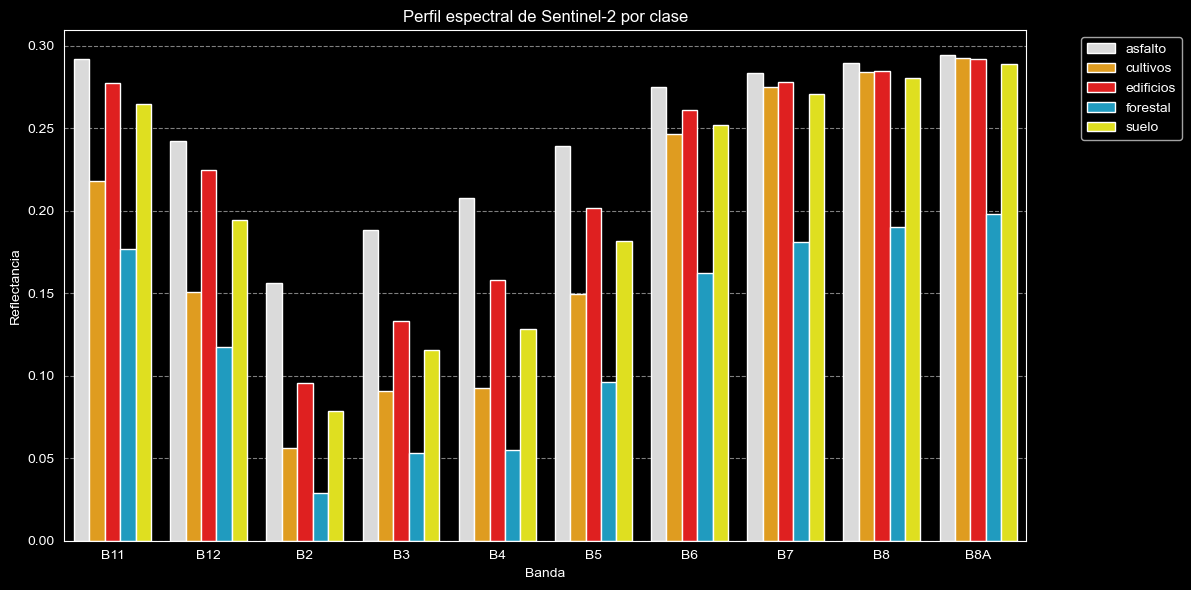

In [23]:
# Muestreo los píxeles clasificados para obtener estadísticas
muestras_s2 = sentinel2_importancia.stratifiedSample(
    numPoints=200,
    classBand="classification",
    region=municipio.geometry(),
    scale=240,
    geometries=False
)

# Convierto los datos en un dataframe de pandas para trabajar con él
df_clases_s2 = geemap.ee_to_df(muestras_s2)

# Defino las etiquetas del gráfico usando el diccionario de la celda anterior
df_clases_s2["Clase"] = df_clases_s2["classification"].map(diccionario_clases).fillna(df_clases_s2["classification"].astype(str))

# Me quedo con las bandas que me interesan (Sentinel-2)
bandas_s2_grafico = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B11", "B12"]

# Transformo a formato largo para dibujar el gráfico
df_s2_largo = df_clases_s2.melt(
    id_vars=["Clase"],
    value_vars=[b for b in bandas_s2_grafico if b in df_clases_s2.columns],
    var_name="Banda",
    value_name="Reflectancia"
)

# Calculo la media por clase y banda
df_s2_media = df_s2_largo.groupby(["Clase", "Banda"]).mean().reset_index()

# Creo el gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_s2_media,
    x="Banda",
    y="Reflectancia",
    hue="Clase",
    palette=palette_dict
)
plt.title("Perfil espectral de Sentinel-2 por clase")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Gráfico del perfil de radar por clase

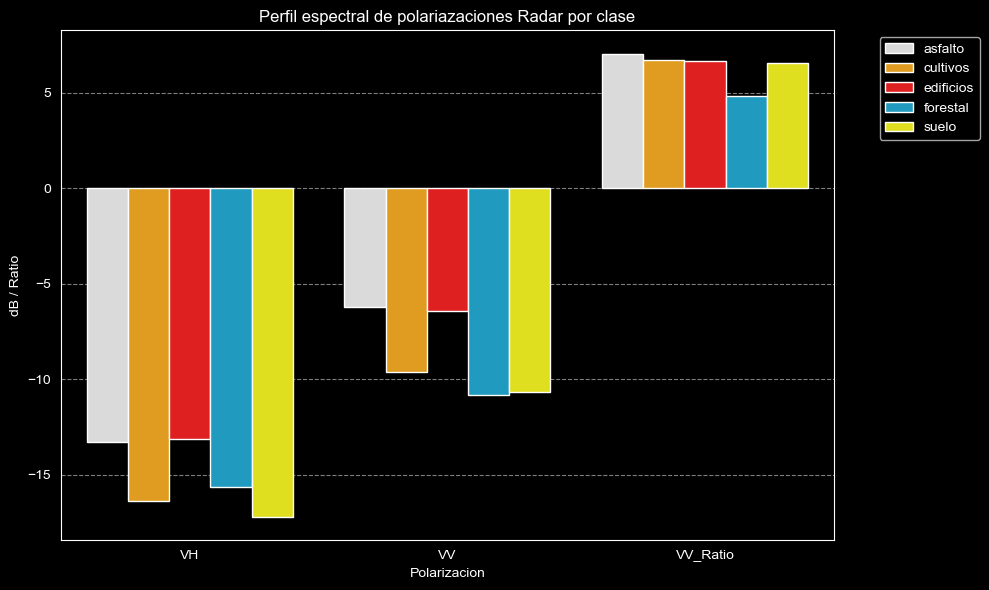

In [24]:
# Muestreo de píxeles clasificados para obtener estadísticas
muestras_s1 = radar_importancia.stratifiedSample(
    numPoints=200,
    classBand="classification",
    region=municipio.geometry(),
    scale=240,
    geometries=False
)

# Convierto los datos en un dataframe de pandas para trabajar con él
df_clases_s1 = geemap.ee_to_df(muestras_s1)

# Defino las etiquetas del gráfico usando el diccionario de la celda genérica de este apartado
df_clases_s1["Clase"] = df_clases_s1["classification"].map(diccionario_clases).fillna(df_clases_s1["classification"].astype(str))

# Bandas radar
bandas_s1_grafico = ["VV", "VH", "VV_Ratio"]

# Transformo a formato largo para dibujar el gráfico
df_s1_largo = df_clases_s1.melt(
    id_vars=["Clase"],
    value_vars=[b for b in bandas_s1_grafico if b in df_clases_s1.columns],
    var_name="Polarizacion",
    value_name="dB / Ratio"
)

# Calculo la media por clase y banda
df_s1_media = df_s1_largo.groupby(["Clase", "Polarizacion"]).mean().reset_index()

# Creo el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_s1_media,
    x="Polarizacion",
    y="dB / Ratio",
    hue="Clase",
    palette=palette_dict
)
plt.title("Perfil espectral de polariazaciones Radar por clase")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Gráfico del perfil de radar por índice

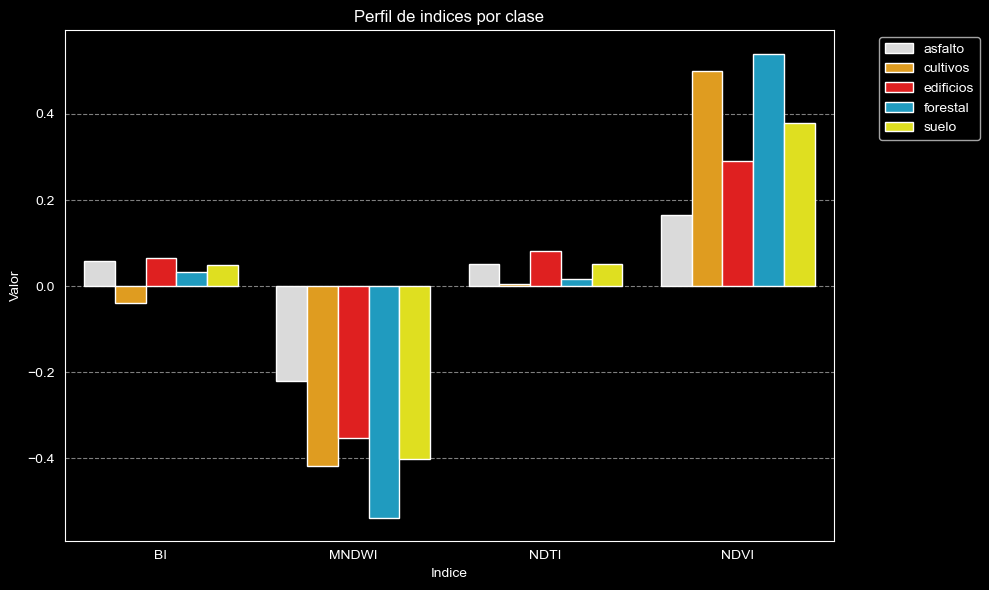

In [25]:
# Muestreo de píxeles clasificados para obtener estadísticas
muestras_indices = indices_importancia.stratifiedSample(
    numPoints=200,
    classBand="classification",
    region=municipio.geometry(),
    scale=240,
    geometries=False
)

# Convierto los datos en un dataframe de pandas para trabajar con él
df_clases_indices = geemap.ee_to_df(muestras_indices)

# Defino las etiquetas del gráfico usando el diccionario de la celda genérica de este apartado
df_clases_indices["Clase"] = df_clases_indices["classification"].map(diccionario_clases).fillna(df_clases_indices["classification"].astype(str))

# Bandas índices
bandas_indices_grafico = ["NDVI", "NDTI", "MNDWI"]

# Transformo a formato largo para dibujar el gráfico
df_indices_largo = df_clases_indices.melt(
    id_vars=["Clase"],
    value_vars=[b for b in bandas_indices_grafico if b in df_clases_indices.columns],
    var_name="Indice",
    value_name="Valor"
)

# Calculo la media por clase e índice
df_indices_media = df_indices_largo.groupby(["Clase", "Indice"]).mean().reset_index()

# Creo el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_indices_media,
    x="Indice",
    y="Valor",
    hue="Clase",
    palette=palette_dict
)
plt.title("Perfil de indices por clase")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
